# AlexNet

In this problem, you are asked to train a deep convolutional neural network to perform image classification. In fact, this is a slight variation of a network called *AlexNet*. This is a landmark model in deep learning, and arguably kickstarted the current (and ongoing, and massive) wave of innovation in modern AI when its results were first presented in 2012. AlexNet was the first real-world demonstration of a *deep* classifier that was trained end-to-end on data and that outperformed all other ML models thus far.

We will train AlexNet using the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. 

![](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

A lot of the code you will need is already provided in this notebook; all you need to do is to fill in the missing pieces, and interpret your results.

**Warning** : AlexNet takes a good amount of time to train (~1 minute per epoch on Google Colab). So please budget enough time to do this homework.


In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [146]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Loading and Preparing the Data


Our dataset is made up of color images but three color channels (red, green and blue), compared to MNIST's black and white images with a single color channel. To normalize our data we need to calculate the means and standard deviations for each of the color channels independently, and  normalize them.

In [147]:
ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

Files already downloaded and verified


In [148]:
# Compute means and standard deviations along the R,G,B channel

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

Next, we will do data augmentation. For each training image we will randomly rotate it (by up to 5 degrees), flip/mirror with probability 0.5, shift by +/-1 pixel. Finally we will normalize each color channel using the means/stds we calculated above.

In [149]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

Next, we'll load the dataset along with the transforms defined above.

We will also create a validation set with 10\% of the training samples. The validation set will be used to monitor loss along different epochs, and we will pick the model along the optimization path that performed the best, and report final test accuracy numbers using this model.

In [150]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [151]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [152]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Now, we'll create a function to plot some of the images in our dataset to see what they actually look like.

Note that by default PyTorch handles images that are arranged `[channel, height, width]`, but `matplotlib` expects images to be `[height, width, channel]`, hence we need to permute the dimensions of our images before plotting them.

In [153]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

One point here: `matplotlib` is expecting the values of every pixel to be between $[0, 1]$, however our normalization will cause them to be outside this range. By default `matplotlib` will then clip these values into the $[0,1]$ range. This clipping causes all of the images to look a bit weird - all of the colors are oversaturated. The solution is to normalize each image between [0,1].

In [154]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

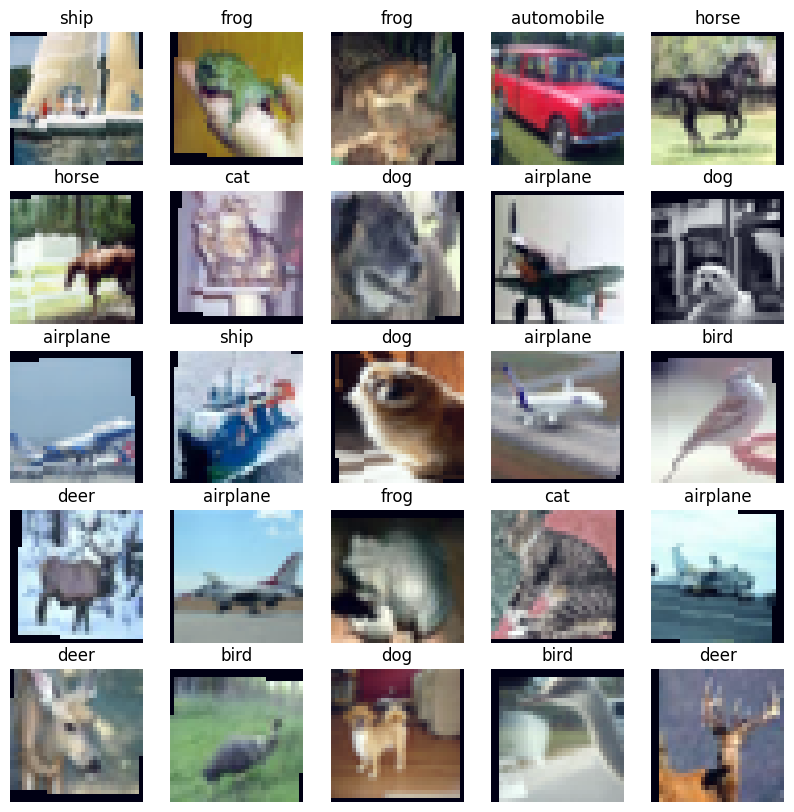

In [155]:
plot_images(images, labels, classes, normalize = True)

We'll be normalizing our images by default from now on, so we'll write a function that does it for us which we can use whenever we need to renormalize an image.

In [156]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

The final bit of the data processing is creating the iterators. We will use a large. Generally, a larger batch size means that our model trains faster but is a bit more susceptible to overfitting.

In [157]:
# Q1: Create data loaders for train_data, valid_data, test_data
# Use batch size 256


# BATCH_SIZE = 

# train_iterator = 

# valid_iterator = 

# test_iterator = 

BATCH_SIZE = 256
train_iterator = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

### Defining the Model

Next up is defining the model.

AlexNet will have the following architecture:

* There are 5 2D convolutional layers (which serve as *feature extractors*), followed by 3 linear layers (which serve as the *classifier*).
* All layers (except the last one) have `ReLU` activations. (Use `inplace=True` while defining your ReLUs.)
* All convolutional filter sizes have kernel size 3 x 3 and padding 1. 
* Convolutional layer 1 has stride 2. All others have the default stride (1).
* Convolutional layers 1,2, and 5 are followed by a 2D maxpool of size 2.
* Linear layers 1 and 2 are preceded by Dropouts with Bernoulli parameter 0.5.

* For the convolutional layers, the number of channels is set as follows. We start with 3 channels and then proceed like this:

  - $3 \rightarrow 64 \rightarrow 192 \rightarrow384\rightarrow256\rightarrow 256$

  In the end, if everything is correct you should get a feature map of size $ 2\times2 \times 256 = 1024$.

* For the linear layers, the feature sizes are as follows:

  - $1024 \rightarrow 4096 \rightarrow 4096 \rightarrow 10$.

  (The 10, of course, is because 10 is the number of classes in CIFAR-10).

In [158]:
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(96, 256, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(256, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), 256 * 6 * 6)
#         x = self.classifier(x)
#         return x

In [159]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(h)
        return x, h


We'll create an instance of our model with the desired amount of classes.

In [160]:
OUTPUT_DIM = 10
model = AlexNet(OUTPUT_DIM)

### Training the Model

We first initialize parameters in PyTorch by creating a function that takes in a PyTorch module, checking what type of module it is, and then using the `nn.init` methods to actually initialize the parameters.

For convolutional layers we will initialize using the *Kaiming Normal* scheme, also known as *He Normal*. For the linear layers we initialize using the *Xavier Normal* scheme, also known as *Glorot Normal*. For both types of layer we initialize the bias terms to zeros.



In [161]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

We apply the initialization by using the model's `apply` method. If your definitions above are correct you should get the printed output as below.

In [162]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(2, 2))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
   



We then define the loss function we want to use, the device we'll use and place our model and criterion on to our device.

In [163]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)




```
# This is formatted as code
```

We define a function to calculate accuracy...

In [164]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc



As we are using dropout we need to make sure to "turn it on" when training by using `model.train()`.

In [165]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We also define an evaluation loop, making sure to "turn off" dropout with `model.eval()`.

In [166]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Next, we define a function to tell us how long an epoch takes.

In [167]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, finally, we train our model.

Train it for 25 epochs (using the train dataset). At the end of each epoch, compute the validation loss and keep track of the best model. You might find the command `torch.save` helpful.

At the end you should expect to see validation losses of ~76% accuracy.

In [168]:
# Q3: train your model here for 25 epochs. 
# Print out training and validation loss/accuracy of the model after each epoch
# Keep track of the model that achieved best validation loss thus far.

EPOCHS = 25

# Fill training code here

best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 01
	Train Loss: 2.385 | Train Acc: 21.71%
	 Val. Loss: 1.613 |  Val. Acc: 39.04%
Epoch: 02
	Train Loss: 1.539 | Train Acc: 43.00%
	 Val. Loss: 1.351 |  Val. Acc: 50.60%
Epoch: 03
	Train Loss: 1.357 | Train Acc: 50.75%
	 Val. Loss: 1.241 |  Val. Acc: 54.72%
Epoch: 04
	Train Loss: 1.256 | Train Acc: 54.90%
	 Val. Loss: 1.141 |  Val. Acc: 58.73%
Epoch: 05
	Train Loss: 1.173 | Train Acc: 58.41%
	 Val. Loss: 1.083 |  Val. Acc: 61.63%
Epoch: 06
	Train Loss: 1.112 | Train Acc: 60.57%
	 Val. Loss: 1.059 |  Val. Acc: 62.47%
Epoch: 07
	Train Loss: 1.066 | Train Acc: 62.07%
	 Val. Loss: 1.018 |  Val. Acc: 65.02%
Epoch: 08
	Train Loss: 1.008 | Train Acc: 64.62%
	 Val. Loss: 0.997 |  Val. Acc: 64.91%
Epoch: 09
	Train Loss: 0.966 | Train Acc: 66.29%
	 Val. Loss: 0.936 |  Val. Acc: 67.48%
Epoch: 10
	Train Loss: 0.929 | Train Acc: 67.48%
	 Val. Loss: 0.919 |  Val. Acc: 68.54%
Epoch: 11
	Train Loss: 0.899 | Train Acc: 68.67%
	 Val. Loss: 0.922 |  Val. Acc: 67.75%
Epoch: 12
	Train Loss: 0.876 | T

# Evaluating the model


We then load the parameters of our model that achieved the best validation loss. You should expect to see ~75% accuracy of this model on the test dataset.

Finally, plot the confusion matrix of this model and comment on any interesting patterns you can observe there. For example, which two classes are confused the most?



In [169]:
# Q4: Load the best performing model, evaluate it on the test dataset, and print test accuracy.

# Also, print out the confusion matrox.


In [170]:
# def get_predictions(model, iterator, device):

#     model.eval()

#     labels = []
#     probs = []

#     # Q4: Fill code here.

   
#     labels = torch.cat(labels, dim = 0)
#     probs = torch.cat(probs, dim = 0)

#     return labels, probs

def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        for batch in iterator:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            labels.append(y)
            probs.append(torch.softmax(y_pred, dim=1))

    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return labels, probs

In [171]:
labels, probs = get_predictions(model, test_iterator, device)

In [172]:
pred_labels = torch.argmax(probs, 1)

In [173]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

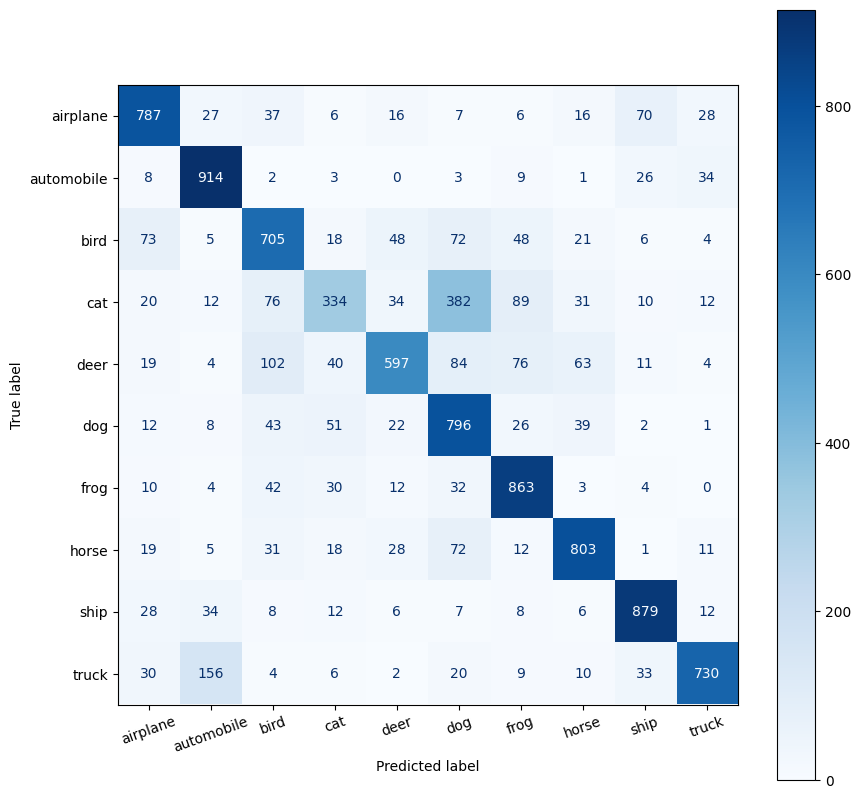

In [174]:
plot_confusion_matrix(labels, pred_labels, classes) 

### Conclusion

That's it! As a side project (this is not for credit and won't be graded), feel free to play around with different design choices that you made while building this network.

- Whether or not to normalize the color channels in the input.
- The learning rate parameter in Adam.
- The batch size.
- The number of training epochs.
- (and if you are feeling brave -- the AlexNet architecture itself.)